## TUIA - Aprendizaje Automático 1

### Trabajo Práctico: Predicción de lluvia en Australia.

### Integrantes:
- Ponce, Daniel
- Yañez, Mirian



El presente informe detalla el trabajo práctico llevado a cabo para la predicción de las condiciones climáticas en Australia, centrándonos en las ciudades de Adelaide, Canberra, Cobar, Dartmoor, Melbourne, MelbourneAirport, MountGambier, Sydney y SydneyAirport. 

El conjunto de datos utilizado se denomina weatherAUS.csv y contiene información climática de los últimos diez años.

## Variables de Interés:

**RainTomorrow y RainfallTomorrow**: Estas variables representan nuestro objetivo de predicción, indicando si lloverá al día siguiente y la cantidad de lluvia, respectivamente.

"RainTomorrow" (categórica, para un problema de clasificación)

"RainfallTomorrow" (continua, para un problema de regresión).

## Paquetes y Librerias

In [1]:
!pip install pandas
!pip install scikit-learn
!pip install seaborn


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import SGDRegressor, Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve
import warnings
warnings.filterwarnings("ignore")

## Importar el dataset

In [3]:
file_path= 'weatherAUS.csv'
df = pd.read_csv(file_path, sep=',')

## Filtramos por las ciudades de interés

In [4]:
ciudades = ['Adelaide', 'Canberra', 'Cobar', 'Dartmoor', 'Melbourne', 'MelbourneAirport', 'MountGambier', 'Sydney', 'SydneyAirport']
df = df[df['Location'].isin(ciudades)]

## Realizamos el split de entrenamiento y prueba 

Decidimos dividir el conjunto de datos de forma manual. Esta elección se debe a que posteriormente imputaremos los valores basados en la fecha. Si utilizáramos la función train_test_split, la separación sería aleatoria, lo que podría provocar una fuga de datos.


In [5]:
test_size = 0.20
train_size = 1 - test_size

total_rows = len(df)
num_test_rows = int(total_rows * test_size)
num_train_rows = total_rows - num_test_rows
train = df.iloc[:num_train_rows]
test = df.iloc[num_train_rows:]

if train.iloc[-1]['Date'] == test.iloc[0]['Date']:
    df['Date'] = pd.to_datetime(df['Date'])
    train = df[df['Date'] < train.iloc[-1]['Date']]
    test = df[df['Date'] >= train.iloc[-1]['Date']]

    print(f"Se volvió a dividir el conjunto de datos. Ahora, en el entrenamiento se toma hasta la fecha {train.iloc[0]['Date']}.")
print(f"El entrenamiento se toma hasta la fecha {train.iloc[-1]['Date']} y el test a partir de la fecha {test.iloc[0]['Date']}.")
print('Total rows: ' + str(total_rows))
print('Total num_test_rows: ' + str(len(test)))
print('Total num_train_rows: ' + str(len(train)))

El entrenamiento se toma hasta la fecha 2010-02-05 y el test a partir de la fecha 2010-02-06.
Total rows: 28233
Total num_test_rows: 5646
Total num_train_rows: 22587


## Análisis descriptivo

Se realizará un análisis exploratorio del conjunto de datos de entrenamiento para entender sus características principales y determinar si se requiere alguna acción para abordar datos faltantes, valores atípicos, la codificación de variables categóricas u otros procesos antes de proceder.

In [6]:
train.columns

Index(['Unnamed: 0', 'Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall',
       'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am',
       'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow', 'RainfallTomorrow'],
      dtype='object')

In [7]:
train.head()

,Unnamed: 0,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
6047,6049,2009-01-01,Cobar,17.9,35.2,0.0,12.0,12.3,SSW,48.0,...,13.0,1006.3,1004.4,2.0,5.0,26.6,33.4,No,No,0.0
6048,6050,2009-01-02,Cobar,18.4,28.9,0.0,14.8,13.0,S,37.0,...,8.0,1012.9,1012.1,1.0,1.0,20.3,27.0,No,No,0.0
6049,6051,2009-01-03,Cobar,15.5,34.1,0.0,12.6,13.3,SE,30.0,...,7.0,NaN,1011.6,NaN,1.0,NaN,32.7,No,No,0.0
6050,6052,2009-01-04,Cobar,19.4,37.6,0.0,10.8,10.6,NNE,46.0,...,22.0,1012.3,1009.2,1.0,6.0,28.7,34.9,No,No,0.0
6051,6053,2009-01-05,Cobar,21.9,38.4,0.0,11.4,12.2,WNW,31.0,...,22.0,1012.7,1009.1,1.0,5.0,29.1,35.6,No,No,0.0


In [8]:
train.info()
train.isna().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 22587 entries, 6047 to 96873
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        22587 non-null  int64  
 1   Date              22587 non-null  object 
 2   Location          22587 non-null  object 
 3   MinTemp           22020 non-null  float64
 4   MaxTemp           22034 non-null  float64
 5   Rainfall          21691 non-null  float64
 6   Evaporation       19955 non-null  float64
 7   Sunshine          17717 non-null  float64
 8   WindGustDir       21011 non-null  object 
 9   WindGustSpeed     21013 non-null  float64
 10  WindDir9am        21269 non-null  object 
 11  WindDir3pm        22180 non-null  object 
 12  WindSpeed9am      22240 non-null  float64
 13  WindSpeed3pm      22260 non-null  float64
 14  Humidity9am       21662 non-null  float64
 15  Humidity3pm       21709 non-null  float64
 16  Pressure9am       21756 non-null  float64


Unnamed: 0             0
Date                   0
Location               0
MinTemp              567
MaxTemp              553
Rainfall             896
Evaporation         2632
Sunshine            4870
WindGustDir         1576
WindGustSpeed       1574
WindDir9am          1318
WindDir3pm           407
WindSpeed9am         347
WindSpeed3pm         327
Humidity9am          925
Humidity3pm          878
Pressure9am          831
Pressure3pm          819
Cloud9am            6650
Cloud3pm            6833
Temp9am              580
Temp3pm              569
RainToday            896
RainTomorrow         895
RainfallTomorrow     895
dtype: int64

### **Hay un total de 22587 datos de entrenamiento, 25 columnas y se puede observar que hay datos nulos en la mayoria de las variables.**

### Eliminamos la columna 'Unnamed: 0' y 'Location'
Eliminamos la columna Location, vamos a considerarlas a todas como una sola

In [9]:
train = train.drop(columns=['Unnamed: 0', 'Location'])

### Cambiamos los valores nulos
Debido a que tomamos las ciudades como una única localidad, decidimos reemplazar los valores faltantes por otro de la misma fecha o, en su defecto por la mas cercana.

In [10]:
train.sort_values(by='Date', inplace=True)
train.fillna(method='ffill', inplace=True)

In [11]:
train.isna().sum()

Date                0
MinTemp             0
MaxTemp             0
Rainfall            0
Evaporation         0
Sunshine            0
WindGustDir         0
WindGustSpeed       0
WindDir9am          0
WindDir3pm          0
WindSpeed9am        0
WindSpeed3pm        0
Humidity9am         0
Humidity3pm         0
Pressure9am         0
Pressure3pm         0
Cloud9am            0
Cloud3pm            0
Temp9am             0
Temp3pm             0
RainToday           0
RainTomorrow        0
RainfallTomorrow    0
dtype: int64

### Eliminamos la columna Date:
La razon es que ya no la vamos a usar, solo la usamos como criterio para el reemplazo de los valores nulos

In [12]:
train = train.drop(columns=['Date'])

In [13]:
train.columns

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow', 'RainfallTomorrow'],
      dtype='object')

## Creacion de columnas 
Con el objetivo de reducir la cantidad de columnas y mejorar la explicabilidad del modelo, decidimos agrupar las variables que representan dos momentos del día en una sola columna.

In [14]:
columns_to_aggregate = ['Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm', 'Humidity9am', 
                        'Humidity3pm', 'Cloud9am', 'Cloud3pm','WindSpeed3pm','WindSpeed9am']
new_columns = []
train['PressureVariation'] = train['Pressure3pm'] - train['Pressure9am']
train['TempVariation'] = train['Temp3pm'] - train['Temp9am']
train['HumidityVariation'] = train['Humidity3pm'] - train['Humidity9am']
train['CloudVariation'] = train['Cloud3pm'] - train['Cloud9am']
train['WindSpeedVariation'] = train['WindSpeed3pm'] - train['WindSpeed9am']
train.drop(columns=columns_to_aggregate, inplace=True)


In [15]:
train.columns

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'RainToday',
       'RainTomorrow', 'RainfallTomorrow', 'PressureVariation',
       'TempVariation', 'HumidityVariation', 'CloudVariation',
       'WindSpeedVariation'],
      dtype='object')

### Estadística descriptiva de las variables numéricas
Examinamos medidas estadísticas, incluyendo valores mínimos, máximos, cuartiles, y medidas de centralidad como la mediana y la media.

In [16]:
train.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,RainfallTomorrow,PressureVariation,TempVariation,HumidityVariation,CloudVariation,WindSpeedVariation
count,22587.000000,22587.000000,22587.000000,22587.000000,22587.000000,22587.000000,22587.000000,22587.000000,22587.000000,22587.000000,22587.000000,22587.000000
mean,11.478705,22.122557,2.083694,4.999141,6.883907,42.391685,2.102634,-2.186993,5.053774,-18.735334,0.052774,4.831850
std,5.907594,6.673457,6.679438,3.655452,3.855443,14.397434,6.737788,2.084982,3.495870,15.902608,2.665999,9.425617
min,-8.000000,4.100000,0.000000,0.000000,0.000000,9.000000,0.000000,-13.900000,-12.100000,-82.000000,-8.000000,-46.000000
25%,7.500000,16.900000,0.000000,2.400000,3.800000,31.000000,0.000000,-3.500000,2.700000,-29.000000,-1.000000,-1.000000
50%,11.200000,21.300000,0.000000,4.200000,7.500000,41.000000,0.000000,-2.400000,4.700000,-18.000000,0.000000,4.000000
75%,15.700000,26.400000,0.800000,6.800000,10.000000,50.000000,0.800000,-1.000000,7.300000,-9.000000,1.000000,11.000000
max,33.900000,46.800000,119.400000,86.200000,14.300000,122.000000,119.400000,10.100000,23.000000,76.000000,8.000000,52.000000


Al analizar las columnas, se percibe que tanto la media como la mediana muestran una cercanía notable, lo que sugiere una tendencia consistente en los datos. Los desvíos en la dispersión de los datos no son extremos y la distribución no presentaria una gran extensión en un boxplot.

Los valores mínimos y máximos registrados estan considerablemente alejados de los valores centrales, lo cual señala la posible existencia de valores atípicos dentro del conjunto de datos.

## **Bloxplot**

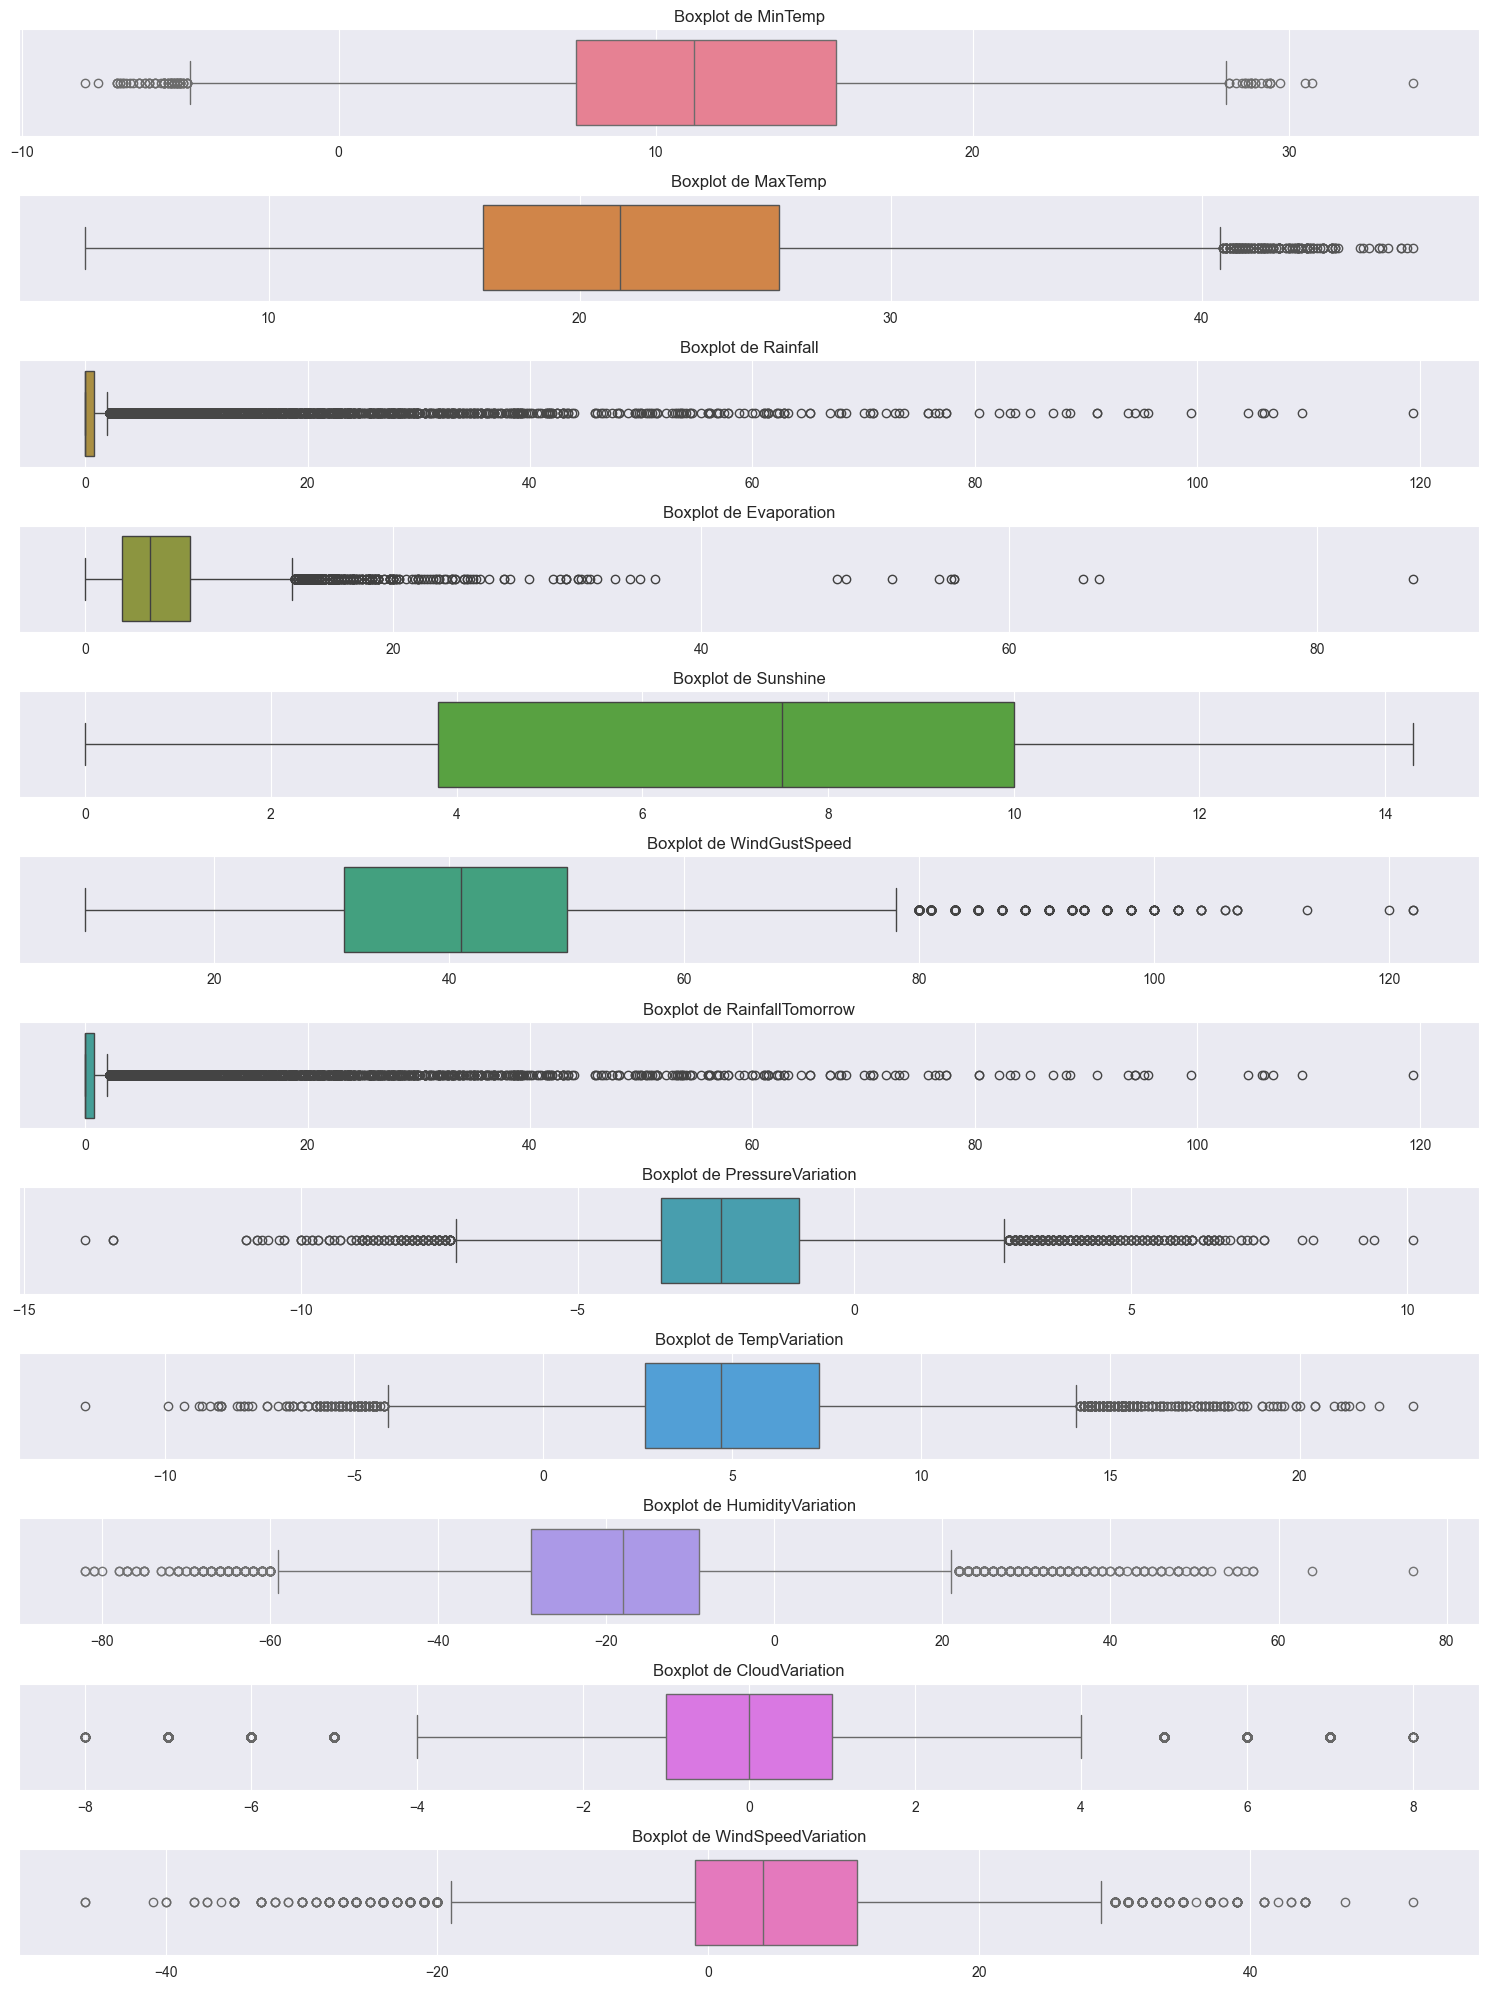

In [17]:
numeric_columns = train.select_dtypes(include=[np.float64]).columns

colores = sns.color_palette('husl', n_colors=len(numeric_columns))

fig, axes = plt.subplots(len(numeric_columns), 1, figsize=(15, 20), sharex=False)

for i, col in enumerate(numeric_columns):
    sns.boxplot(data=train, x=col, ax=axes[i], color=colores[i], orient='h')
    axes[i].set_title(f'Boxplot de {col}')
    axes[i].set_xlabel('')

plt.tight_layout()

plt.show()

## Histograma

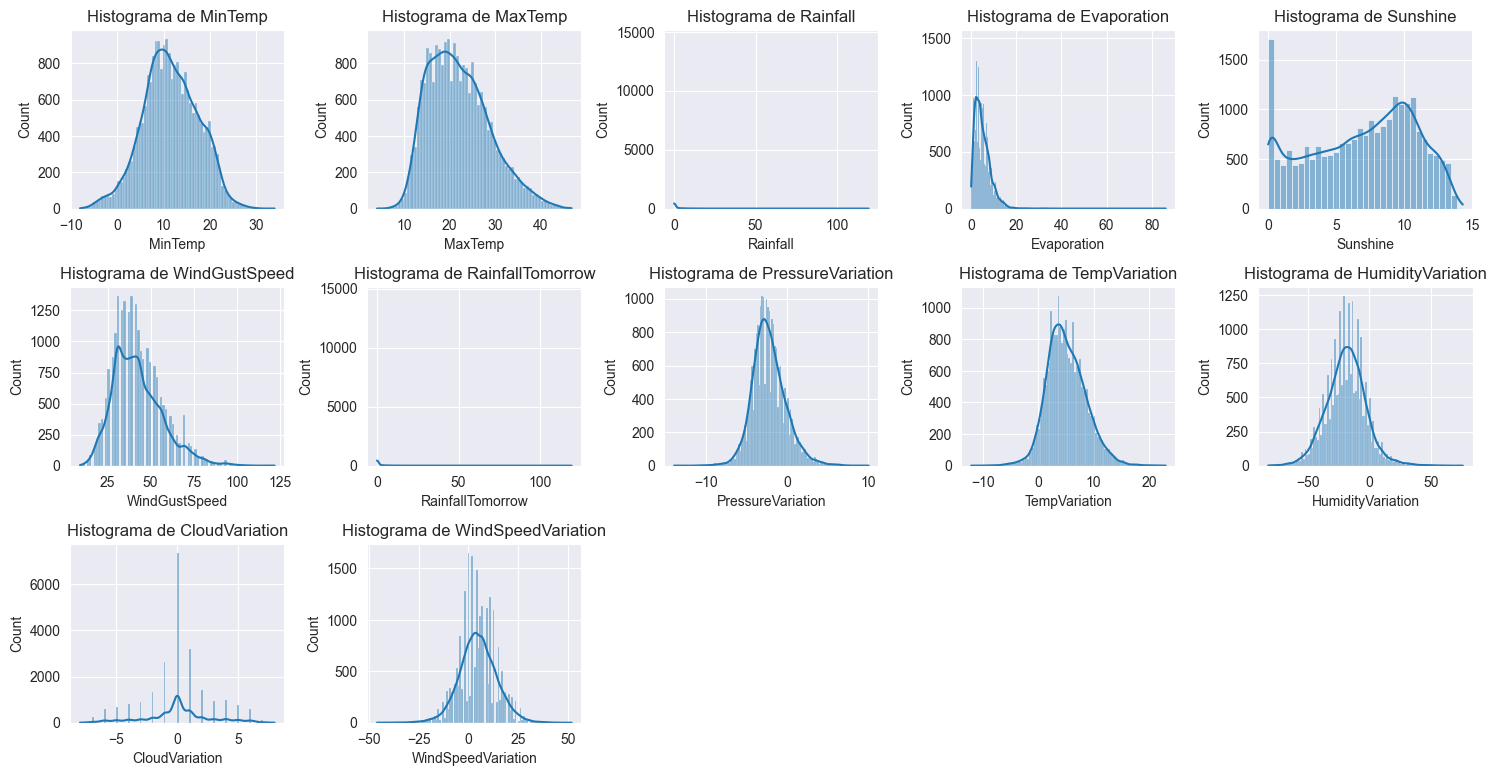

In [18]:
numeric_columns = train.select_dtypes(include=[np.float64]).columns

plt.figure(figsize=(15, 10))
for i, column in enumerate(numeric_columns, 1):
    plt.subplot(4, 5, i)
    sns.histplot(train[column].dropna(), kde=True)
    plt.title(f'Histograma de {column}')

plt.tight_layout()
plt.show()

Para comprender más a fondo el comportamiento de los datos, empleamos histogramas donde se puede apreciar que algunas variables exhiben una distribución más uniforme de sus valores, como es el caso de la temperatura, humedad y presión. Por otro lado, existen variables que muestran la presencia de múltiples modas en los datos y una distribución menos uniforme.

Asimismo, se destaca que la variable Rainfall concentra la gran mayoría de sus datos en cero.

## Analizamos nuestra variable objetivo, la que queremos predecir para saber si el dataset esta balanceado o no.
Primero convertimos las variables categóricas en numéricas

In [19]:
train['RainToday'] = train['RainToday'].map({'No': 0, 'Yes': 1})
train['RainTomorrow'] = train['RainTomorrow'].map({'No': 0, 'Yes': 1})

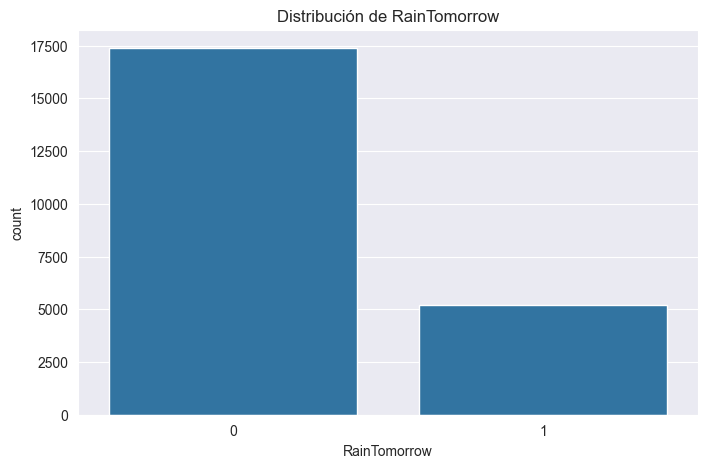

In [20]:
plt.figure(figsize=(8, 5))
sns.countplot(x='RainTomorrow', data=train)
plt.title('Distribución de RainTomorrow')
plt.show()

### Se observa que hay una mayor cantidad de datos donde no llueve (0) comparado con los días que llueve (1). Esto puede hacer que el modelo tenga un sesgo muy importante al momento de predecir. Por esta razón, podemos decir que los datos no se encuentran balanceados.
Podemos ver una relacion 3 a 1 aproximadamente, en este caso existe la posibilidad de balancear el dataset.

# Matriz de correlación 

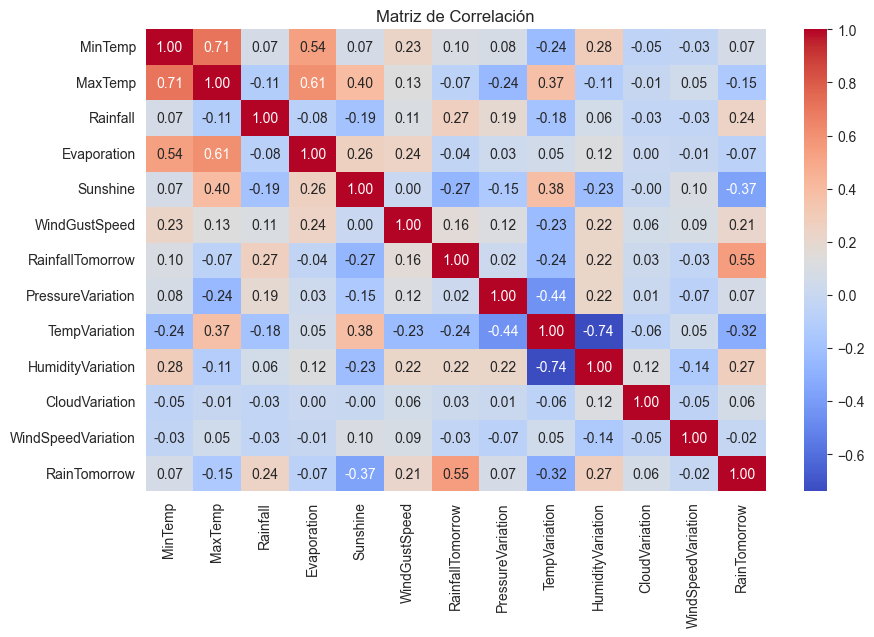

In [21]:
numeric_columns = numeric_columns.append(pd.Index(['RainTomorrow']))
correlation_matrix_numeric = train[numeric_columns].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix_numeric, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación')
plt.show()

Podemos observar que las variables con mayor correlación positiva con RainfallTomorrow son:

*   Rainfall (0.27)
*   Cloud3pm (0.25)
*   HumidityVariation (0.22)
*   WindGustSpeed (0.16)
*   MinTemp       (0.10)

Las variables con mayor correlación negativa con RainfallTomorrow son:
*   Sunshine (-0.27)
*   TempVariation (-0.24)

Las variables con mayor correlación positiva con RainTomorrow son:

*   RainfallTomorrow (0.55)
*   HumidityVariation (0,27)
*   Rainfall (0.24)
*   WindGustSpeed (0,21)

Las variables con mayor correlación negativa con RainTomorrow son:
*   Sunshine (-0.37)
*   TempVariation (-0.32)

## Para poder ver las metricas de test necesitamos aplicarle los mismos cambios que se hicieron en train.

In [22]:
test.sort_values(by='Date', inplace=True)

for column in test.columns:
    test[column] = test[column].ffill()
    test[column] = test[column].bfill() 
    
columns_to_aggregate = ['Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm', 'Humidity9am', 
                        'Humidity3pm', 'Cloud9am', 'Cloud3pm','WindSpeed3pm','WindSpeed9am']
new_columns = []
test = test.drop(columns=['Unnamed: 0', 'Location','Date'])
test['PressureVariation'] = test['Pressure3pm'] - test['Pressure9am']
test['TempVariation'] = test['Temp3pm'] - test['Temp9am']
test['HumidityVariation'] = test['Humidity3pm'] - test['Humidity9am']
test['CloudVariation'] = test['Cloud3pm'] - test['Cloud9am']
test['WindSpeedVariation'] = test['WindSpeed3pm'] - test['WindSpeed9am']
test.drop(columns=columns_to_aggregate, inplace=True)
test['RainToday'] = test['RainToday'].map({'No': 0, 'Yes': 1})
test['RainTomorrow'] = test['RainTomorrow'].map({'No': 0, 'Yes': 1})


# Método LinearRegression

Evaluamos el modelo con los datos de entrenamiento y luego con los de test

In [23]:
# Seleccionar las variables predictoras (características) y la variable de respuesta (y) para ambos conjuntos
X_train = train.drop(['RainfallTomorrow','WindGustDir','WindDir9am','WindDir3pm','RainTomorrow'], axis=1)
y_train = train['RainfallTomorrow']
y_train_clasification =train['RainTomorrow']
X_test = test.drop(['RainfallTomorrow','WindGustDir','WindDir9am','WindDir3pm','RainTomorrow'], axis=1)
y_test_clasification = test['RainTomorrow']
y_test = test['RainfallTomorrow']

# Entrenar el modelo de regresión lineal
model = LinearRegression()
model.fit(X_train, y_train)

# Hacer predicciones sobre los datos de entrenamiento y de prueba
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Calcular métricas sobre los datos de entrenamiento
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
mape_train = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100

# Calcular métricas sobre los datos de prueba
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
mape_test = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

# Imprimir las métricas
print("Métricas sobre los datos de entrenamiento:")
print("Mean Squared Error (Train):", mse_train)
print("R-squared (Train):", r2_train)
print("Mean Absolute Error (MAE) (Train):", mae_train)
print("Mean Absolute Percentage Error (MAPE) (Train):", mape_train)

print("\nMétricas sobre los datos de prueba:")
print("Mean Squared Error (Test):", mse_test)
print("R-squared (Test):", r2_test)
print("Mean Absolute Error (MAE) (Test):", mae_test)
print("Mean Absolute Percentage Error (MAPE) (Test):", mape_test)


Métricas sobre los datos de entrenamiento:
Mean Squared Error (Train): 37.51175732491574
R-squared (Train): 0.1736729097318831
Mean Absolute Error (MAE) (Train): 2.8973299081690467
Mean Absolute Percentage Error (MAPE) (Train): inf

Métricas sobre los datos de prueba:
Mean Squared Error (Test): 20.450098942947015
R-squared (Test): 0.1804266965789162
Mean Absolute Error (MAE) (Test): 2.4872058972089723
Mean Absolute Percentage Error (MAPE) (Test): inf


### No se observa presencia de overfiting, podemos notar que las metricas de train y test son bastante similares

# Método de gradiente descendiente

In [42]:
sgd_model = SGDRegressor(loss='squared_error', max_iter=3000, random_state=42)
sgd_model.fit(X_train, y_train)

# Hacer predicciones
y_pred_train = sgd_model.predict(X_train)
y_pred_test = sgd_model.predict(X_test)

# Calcular métricas
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
mape_train = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100

mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
mape_test = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

# Imprimir las métricas
print("Métricas sobre los datos de entrenamiento:")
print("Mean Squared Error (Train):", mse_train)
print("R-squared (Train):", r2_train)
print("Mean Absolute Error (MAE) (Train):", mae_train)
print("Mean Absolute Percentage Error (MAPE) (Train):", mape_train)

print("\nMétricas sobre los datos de prueba:")
print("Mean Squared Error (Test):", mse_test)
print("R-squared (Test):", r2_test)
print("Mean Absolute Error (MAE) (Test):", mae_test)
print("Mean Absolute Percentage Error (MAPE) (Test):", mape_test)

Métricas sobre los datos de entrenamiento:
Mean Squared Error (Train): 78.63301827902305
R-squared (Train): -0.732166068112905
Mean Absolute Error (MAE) (Train): 6.22766337141392
Mean Absolute Percentage Error (MAPE) (Train): inf

Métricas sobre los datos de prueba:
Mean Squared Error (Test): 50.468246088348856
R-squared (Test): -1.022602789350398
Mean Absolute Error (MAE) (Test): 5.162891537804172
Mean Absolute Percentage Error (MAPE) (Test): inf


Notamos en este método, que las métricas de r2 comparadas con la regresión lineal son peores.

# Métodos de regularización Lasso

In [25]:
# Crear y entrenar el modelo Lasso
lasso_model = Lasso(alpha=0.1)  # alpha es el parámetro de regularización
lasso_model.fit(X_train, y_train)

# Hacer predicciones
y_pred_train = lasso_model.predict(X_train)
y_pred_test = lasso_model.predict(X_test)

# Calcular métricas
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
mape_train = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100

mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
mape_test = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

# Imprimir las métricas
print("Métricas sobre los datos de entrenamiento:")
print("Mean Squared Error (Train):", mse_train)
print("R-squared (Train):", r2_train)
print("Mean Absolute Error (MAE) (Train):", mae_train)
print("Mean Absolute Percentage Error (MAPE) (Train):", mape_train)

print("\nMétricas sobre los datos de prueba:")
print("Mean Squared Error (Test):", mse_test)
print("R-squared (Test):", r2_test)
print("Mean Absolute Error (MAE) (Test):", mae_test)
print("Mean Absolute Percentage Error (MAPE) (Test):", mape_test)


Métricas sobre los datos de entrenamiento:
Mean Squared Error (Train): 37.598273789545225
R-squared (Train): 0.17176708330369594
Mean Absolute Error (MAE) (Train): 2.873306519513015
Mean Absolute Percentage Error (MAPE) (Train): inf

Métricas sobre los datos de prueba:
Mean Squared Error (Test): 20.66108828080852
R-squared (Test): 0.17197093168994393
Mean Absolute Error (MAE) (Test): 2.4802863334988015
Mean Absolute Percentage Error (MAPE) (Test): inf


# Regresion de Ridge

In [26]:
# Crear y entrenar el modelo Ridge
ridge_model = Ridge(alpha=0.1)  # alpha es el parámetro de regularización
ridge_model.fit(X_train, y_train)

# Hacer predicciones
y_pred_train = ridge_model.predict(X_train)
y_pred_test = ridge_model.predict(X_test)

# Calcular métricas
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
mape_train = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100

mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
mape_test = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

# Imprimir las métricas
print("Métricas sobre los datos de entrenamiento:")
print("Mean Squared Error (Train):", mse_train)
print("R-squared (Train):", r2_train)
print("Mean Absolute Error (MAE) (Train):", mae_train)
print("Mean Absolute Percentage Error (MAPE) (Train):", mape_train)

print("\nMétricas sobre los datos de prueba:")
print("Mean Squared Error (Test):", mse_test)
print("R-squared (Test):", r2_test)
print("Mean Absolute Error (MAE) (Test):", mae_test)
print("Mean Absolute Percentage Error (MAPE) (Test):", mape_test)


Métricas sobre los datos de entrenamiento:
Mean Squared Error (Train): 37.51175732504958
R-squared (Train): 0.1736729097289348
Mean Absolute Error (MAE) (Train): 2.897329086887913
Mean Absolute Percentage Error (MAPE) (Train): inf

Métricas sobre los datos de prueba:
Mean Squared Error (Test): 20.450102777542437
R-squared (Test): 0.1804265429008316
Mean Absolute Error (MAE) (Test): 2.4872055032542946
Mean Absolute Percentage Error (MAPE) (Test): inf


## Método de regularización Elasticnet

In [27]:
elastic_net_model = ElasticNet(alpha=0.1, l1_ratio=0.5)  # alpha es el parámetro de regularización, l1_ratio controla la proporción de L1 y L2
elastic_net_model.fit(X_train, y_train)

# Hacer predicciones
y_pred_train = elastic_net_model.predict(X_train)
y_pred_test = elastic_net_model.predict(X_test)

# Calcular métricas
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
mape_train = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100

mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
mape_test = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

# Imprimir las métricas
print("Métricas sobre los datos de entrenamiento:")
print("Mean Squared Error (Train):", mse_train)
print("R-squared (Train):", r2_train)
print("Mean Absolute Error (MAE) (Train):", mae_train)
print("Mean Absolute Percentage Error (MAPE) (Train):", mape_train)

print("\nMétricas sobre los datos de prueba:")
print("Mean Squared Error (Test):", mse_test)
print("R-squared (Test):", r2_test)
print("Mean Absolute Error (MAE) (Test):", mae_test)
print("Mean Absolute Percentage Error (MAPE) (Test):", mape_test)

Métricas sobre los datos de entrenamiento:
Mean Squared Error (Train): 37.55045479356414
R-squared (Train): 0.17282046322045996
Mean Absolute Error (MAE) (Train): 2.880236760652022
Mean Absolute Percentage Error (MAPE) (Train): inf

Métricas sobre los datos de prueba:
Mean Squared Error (Test): 20.56681531354388
R-squared (Test): 0.17574908491159558
Mean Absolute Error (MAE) (Test): 2.479993846997085
Mean Absolute Percentage Error (MAPE) (Test): inf


### Con respecto a las métricas, elegimos el r2 para comparar los distintos modelos
### Necesitamos comparar los resultados obtenidos tanto en entrenamiento como en prueba para poder determinar si nuestro modelo esta ajustando correctamente.
### Consideramos que nuestro fitting es aceptable teniendo en cuenta la naturaleza de los datos, ya que pudimos observar que el 80% de los datos que tomamos para nuestro conjunto de entrenamiento corresponde a fechas de un periodo de 2 años y esta intentando predecir para los siguientes 7 años.

# Regresión Logística

In [28]:
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train, y_train_clasification)

# Hacer predicciones
y_pred_train = logistic_model.predict(X_train)
y_pred_test = logistic_model.predict(X_test)

# Calcular métricas
accuracy_train = accuracy_score(y_train_clasification, y_pred_train)
accuracy_test = accuracy_score(y_test_clasification, y_pred_test)
precision_train = precision_score(y_train_clasification, y_pred_train)
precision_test = precision_score(y_test_clasification, y_pred_test)
recall_train = recall_score(y_train_clasification, y_pred_train)
recall_test = recall_score(y_test_clasification, y_pred_test)
f1_train = f1_score(y_train_clasification, y_pred_train)
f1_test = f1_score(y_test_clasification, y_pred_test)

# Imprimir las métricas
print("Métricas sobre los datos de entrenamiento:")
print("Accuracy (Train):", accuracy_train)
print("Precision (Train):", precision_train)
print("Recall (Train):", recall_train)
print("F1 Score (Train):", f1_train)

print("\nMétricas sobre los datos de prueba:")
print("Accuracy (Test):", accuracy_test)
print("Precision (Test):", precision_test)
print("Recall (Test):", recall_test)
print("F1 Score (Test):", f1_test)

Métricas sobre los datos de entrenamiento:
Accuracy (Train): 0.8225970691105503
Precision (Train): 0.688783570300158
Recall (Train): 0.4190695886197616
F1 Score (Train): 0.5210947771005139

Métricas sobre los datos de prueba:
Accuracy (Test): 0.808182784272051
Precision (Test): 0.7468499427262314
Recall (Test): 0.43064729194187584
F1 Score (Test): 0.5462924172601592


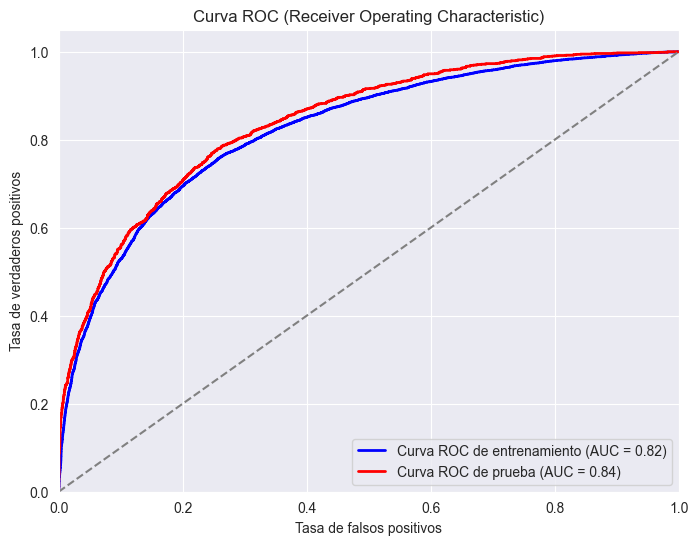

In [29]:
# Obtener las probabilidades de predicción de la clase positiva para entrenamiento y prueba
y_pred_proba_train = logistic_model.predict_proba(X_train)[:, 1]
y_pred_proba_test = logistic_model.predict_proba(X_test)[:, 1]

# Calcular la curva ROC para entrenamiento y prueba
fpr_train, tpr_train, _ = roc_curve(y_train_clasification, y_pred_proba_train)
fpr_test, tpr_test, _ = roc_curve(y_test_clasification, y_pred_proba_test)

# Calcular el área bajo la curva ROC (AUC) para entrenamiento y prueba
auc_train = roc_auc_score(y_train_clasification, y_pred_proba_train)
auc_test = roc_auc_score(y_test_clasification, y_pred_proba_test)

# Trazar las curvas ROC para entrenamiento y prueba
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label='Curva ROC de entrenamiento (AUC = %0.2f)' % auc_train)
plt.plot(fpr_test, tpr_test, color='red', lw=2, label='Curva ROC de prueba (AUC = %0.2f)' % auc_test)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC (Receiver Operating Characteristic)')
plt.legend(loc='lower right')
plt.show()

## Modelo Clasificar base 

In [30]:
from sklearn.dummy import DummyClassifier

# Crear el clasificador ingenuo que predice la clase mayoritaria
naive_classifier = DummyClassifier(strategy="most_frequent")

# Entrenar el modelo con los datos de entrenamiento
naive_classifier.fit(X_train, y_train_clasification)

# Hacer predicciones sobre los datos de entrenamiento y prueba
y_pred_train = naive_classifier.predict(X_train)
y_pred_test = naive_classifier.predict(X_test)

# Evaluar la precisión del modelo en los datos de entrenamiento
accuracy_train = accuracy_score(y_train_clasification, y_pred_train)
print("Precisión del modelo ingenuo en datos de entrenamiento:", accuracy_train)

# Evaluar la precisión del modelo en los datos de prueba
accuracy_test = accuracy_score(y_test_clasification, y_pred_test)
print("Precisión del modelo ingenuo en datos de prueba:", accuracy_test)


Precisión del modelo ingenuo en datos de entrenamiento: 0.7696905299508567
Precisión del modelo ingenuo en datos de prueba: 0.7318455543747786


## curva ROC de modelo base

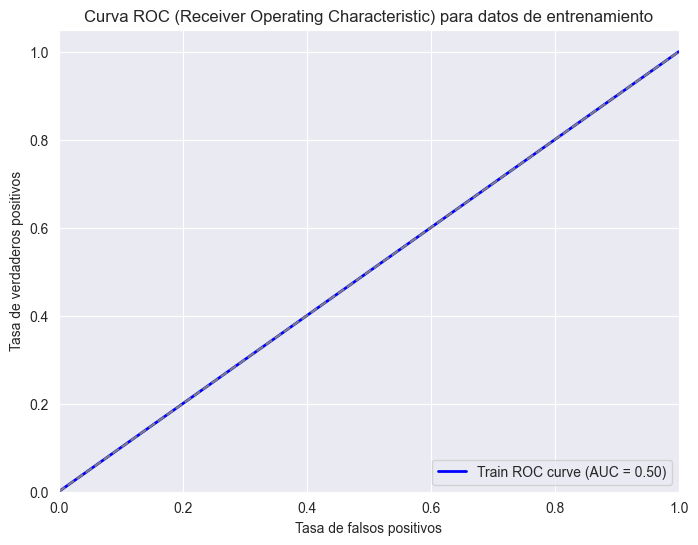

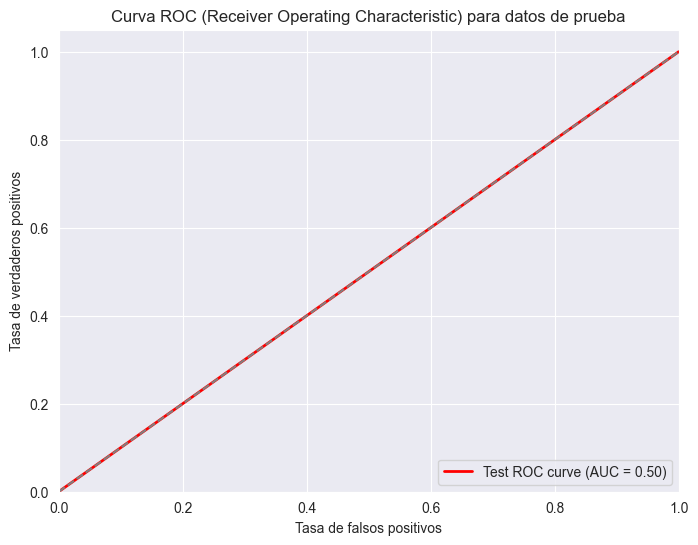

In [31]:
# Obtener las probabilidades de predicción de la clase positiva (la clase mayoritaria)
y_pred_proba_train = np.full_like(y_train_clasification, fill_value=1)  # Clase mayoritaria
y_pred_proba_test = np.full_like(y_test_clasification, fill_value=1)  # Clase mayoritaria

# Calcular la curva ROC para los datos de entrenamiento y prueba
fpr_train, tpr_train, _ = roc_curve(y_train_clasification, y_pred_proba_train)
fpr_test, tpr_test, _ = roc_curve(y_test_clasification, y_pred_proba_test)

# Calcular el área bajo la curva ROC (AUC) para los datos de entrenamiento y prueba
auc_train = roc_auc_score(y_train_clasification, y_pred_proba_train)
auc_test = roc_auc_score(y_test_clasification, y_pred_proba_test)

# Trazar la curva ROC para los datos de entrenamiento
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label='Train ROC curve (AUC = %0.2f)' % auc_train)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC (Receiver Operating Characteristic) para datos de entrenamiento')
plt.legend(loc='lower right')
plt.show()

# Trazar la curva ROC para los datos de prueba
plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, color='red', lw=2, label='Test ROC curve (AUC = %0.2f)' % auc_test)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.title('Curva ROC (Receiver Operating Characteristic) para datos de prueba')
plt.legend(loc='lower right')
plt.show()

## Modelo Regresion base 

In [32]:
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Crear un DummyRegressor que predice la media de la variable objetivo
dummy_regressor = DummyRegressor(strategy='mean')

# Entrenar el modelo de regresión base con los datos de entrenamiento
dummy_regressor.fit(X_train, y_train)

# Hacer predicciones con el modelo de regresión base en los datos de entrenamiento y prueba
y_pred_train_base = dummy_regressor.predict(X_train)
y_pred_test_base = dummy_regressor.predict(X_test)

# Calcular el error cuadrático medio (MSE) del modelo de regresión base para el conjunto de entrenamiento y prueba
mse_train_base = mean_squared_error(y_train, y_pred_train_base)
mse_test_base = mean_squared_error(y_test, y_pred_test_base)

# Calcular el Error Absoluto Medio (MAE) para el conjunto de entrenamiento y prueba
mae_train_base = mean_absolute_error(y_train, y_pred_train_base)
mae_test_base = mean_absolute_error(y_test, y_pred_test_base)

# Calcular el Error Porcentual Absoluto Medio (MAPE) para el conjunto de prueba
mape_test_base = np.mean(np.abs((y_test - y_pred_test_base) / y_test)) * 100

# Calcular el coeficiente de determinación (R-cuadrado) para el conjunto de prueba
r2_test_base = r2_score(y_test, y_pred_test_base)

# Imprimir las métricas
print("Métricas para el modelo de regresión base:")
print("Error cuadrático medio (MSE) (Train):", mse_train_base)
print("Error cuadrático medio (MSE) (Test):", mse_test_base)
print("Mean Absolute Error (MAE) (Train):", mae_train_base)
print("Mean Absolute Error (MAE) (Test):", mae_test_base)
print("Mean Absolute Percentage Error (MAPE) (Test):", mape_test_base)
print("R-squared (Test):", r2_test_base)


Métricas para el modelo de regresión base:
Error cuadrático medio (MSE) (Train): 45.395773376792434
Error cuadrático medio (MSE) (Test): 25.006216572535788
Mean Absolute Error (MAE) (Train): 3.173473524406602
Mean Absolute Error (MAE) (Test): 2.7639919457493134
Mean Absolute Percentage Error (MAPE) (Test): inf
R-squared (Test): -0.0021676462100677085
